# Your name: Guangxuan Xiao

## Starter Code

This notebook implements starter code to help you get started with the assignment. This starter code can be used for a person computer with a GPU or Google Colab.

To use GPU acceleration with Google Colab, select 'GPU' in Edit > Notebook settings > Hardware accelerator.

The code should run properly from start to finish without changes. Various code snippets have been marked with a __TODO__ comment, indicating suggested areas to modify or improve on. Ctrl + F to find those locations. You are welcome to modify this notebook as you wish or start from scratch.

In [31]:
import os
import time
import datetime
import random
import math

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import (DataLoader, Dataset)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

In [32]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [34]:
# Check the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

Using the GPU!


In [35]:
# this code cell contains functions related to the lab
# there should be NO need to modify anything within this cell

def get_network_complexity_info(activation_size, energy, latency):
    """
    Generate network complexity info
    """
    info = {}
    info['activation'] = activation_size
    info['energy'] = energy
    info['latency'] = latency
    return info

def get_lab_score(accuracy, network_complexity):
    """
    Calculates your lab score. We will compute your lab score seperately when grading.
    """
    error_rate = (1 - accuracy) * 100
    loss = error_rate / 12 + network_complexity['latency'] / 0.3
    
    if error_rate > 50:
        return (0, loss)
    elif network_complexity['activation'] > 1000000:
        return (0, loss)
    else:
        score = 0
        if network_complexity['energy'] > 2:
            score += 0
        elif network_complexity['energy'] > 1.5:
            score += 5
        elif network_complexity['energy'] > 1:
            score += 10
        elif network_complexity['energy'] > 0.5:
            score += 15
        else:
            score += 20
            
        if network_complexity['latency'] > 1:
            score += 0
        elif network_complexity['latency'] > 0.5:
            score += 5
        elif network_complexity['latency'] > 0.25:
            score += 10
        elif network_complexity['latency'] > 0.1:
            score += 15
        else:
            score += 20
            
        if error_rate < 20:
            score += 60
        elif error_rate < 30:
            score += 50
        elif error_rate < 40:
            score += 40
        else:
            score += 30
            
        return (score, loss)

In [36]:
# other utility functions
def get_timestamp():
    return datetime.datetime.now().strftime("%m-%d-%Y %I-%M%p")

## Load the dataset

In [37]:
def load_data(batch_size) :
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                          std=(0.247, 0.243, 0.261))
        ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

    train_size, val_size = (len(trainset)-10000), 10000
    train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
        
    dataloaders = {}
    dataloaders['train'] = trainloader
    dataloaders['val'] = validloader
    dataloaders['test'] = testloader
    
    return dataloaders

In [38]:
batch_size = 64
dataloaders = load_data(batch_size)

Files already downloaded and verified


KeyboardInterrupt: 

## Visualize the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch Image Size torch.Size([64, 3, 32, 32])


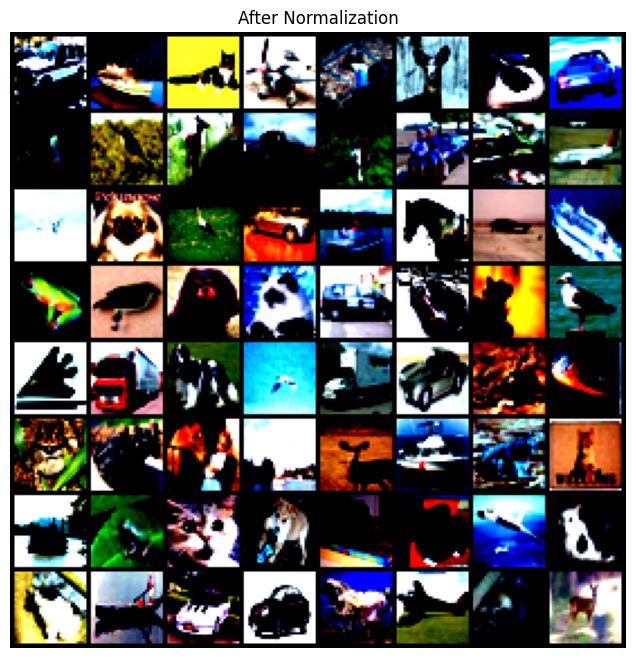

In [ ]:
for images, _ in dataloaders['train']:
    print('Batch Image Size', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=8).permute((1, 2, 0)))
    plt.title("After Normalization")
    break


## Network Definition

You will need to use a better network architecture here. Once finished, copy the network definition to `network-profile.ipynb` and run the energy/latency estimation, before generating the submission file (below).

In [86]:
# define your own model [TODO]
# HINT : You might want to consider a network using depth-wise convolution and residual connection!
# define your own model [TODO]
# HINT : You might want to consider a network using depth-wise convolution and residual connection!

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride):
        super(InvertedResidual, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
            nn.BatchNorm2d(oup),
            nn.ReLU6(inplace=True),
            nn.Conv2d(oup, oup, 3, 1, 1, bias=False),
            nn.BatchNorm2d(oup),
        )
        self.downsample = nn.Sequential(
            nn.Conv2d(inp, oup, 1, stride=stride, bias=False),
            nn.BatchNorm2d(oup),
        )

    def forward(self, x):
        residual = x
        x = self.conv(x)
        x += self.downsample(residual)
        x = F.relu6(x)
        return x


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # build a network with InvertedResidual
        layers = []
        layers.append(nn.Conv2d(3, 16, 3, 1, 1, bias=False))
        layers.append(nn.BatchNorm2d(16))
        layers.append(nn.ReLU6(inplace=True))
        layers.append(InvertedResidual(16, 32, 2))
        layers.append(InvertedResidual(32, 64, 2))
        layers.append(InvertedResidual(64, 64, 2))
        layers.append(InvertedResidual(64, 128, 2))
        layers.append(nn.AdaptiveAvgPool2d((1, 1)))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(128, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


## Training

In [95]:
# instantiate model
model = Net()
model = model.to(device)

In [96]:
# load old model weights if you wish to continue traning from an old model
# past_train_weights = os.path.join("./", "[TODO]"))
# model.load_state_dict(torch.load(past_train_weights))

In [97]:
# setup loss function and optimization
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# [TODO] change parameters of SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3) 
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 8, 12, 16, 20, 24, 28], gamma=0.4)

In [98]:
# train network
# [TODO] Change #epochs to train (Should not exceed 30)
num_epochs = 28 # <30

train_loss_log = []
train_acc_log = []
val_loss_log = []
val_acc_log = []

for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    print("-" * 10)
    # training loop
    print("Training")
    model.train()
        
    running_loss = 0.0
    running_correct = 0
    running_count = 0
    
    pbar = tqdm(dataloaders['train'])
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # get model outputs and calculate loss
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # compute predictions
        _, preds = torch.max(outputs, dim=1)
        correct = torch.sum(preds == labels).item()
        
        # calculate metrics
        running_loss += loss.detach().item() * inputs.size(0)
        running_correct += correct
        running_count += inputs.size(0)
        avg_loss = running_loss / running_count
        avg_acc = running_correct / running_count
        pbar.set_description("Avg. Loss: {:.4f}, Avg. Acc: {:.4f}, LR: {:.4f}".format(avg_loss, avg_acc, optimizer.param_groups[0]['lr']))
    lr_scheduler.step()
    # log metrics
    train_loss_log.append(avg_loss)
    train_acc_log.append(avg_acc)
    pbar.close()
    
    # validation loop
    print("Validation")
    model.eval()
    
    running_loss = 0.0
    running_correct = 0
    running_count = 0
    
    pbar = tqdm(dataloaders['val'])
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # get model outputs and calculate loss
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        # compute predictions
        _, preds = torch.max(outputs, dim=1)
        correct = torch.sum(preds == labels).item()
        
        # calculate metrics
        running_loss += loss.detach().item() * inputs.size(0)
        running_correct += correct
        running_count += inputs.size(0)
        avg_loss = running_loss / running_count
        avg_acc = running_correct / running_count
        pbar.set_description("Avg. Loss: {:.4f}, Avg. Acc: {:.4f}".format(avg_loss, avg_acc))
    
    # log metrics
    val_loss_log.append(avg_loss)
    val_acc_log.append(avg_acc)
    pbar.close()

Epoch 1/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/28
----------
Training


  0%|          | 0/625 [00:00<?, ?it/s]

Validation


  0%|          | 0/157 [00:00<?, ?it/s]

## Evaluation

Training metrics

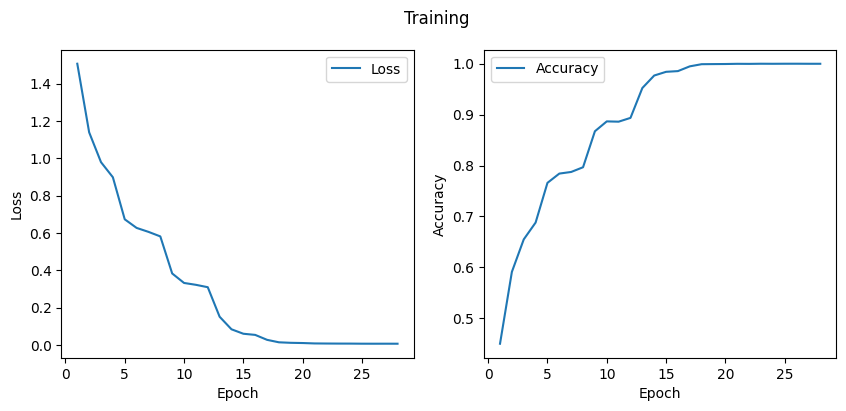

In [99]:
train_epochs = np.arange(len(train_loss_log)) + 1

fig = plt.figure(figsize=(10, 4))
fig.suptitle("Training")

ax = fig.add_subplot(1, 2, 1)
ax.plot(train_epochs, train_loss_log, label='Loss')
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_epochs, train_acc_log, label='Accuracy')
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

fig.show()

Testing metrics

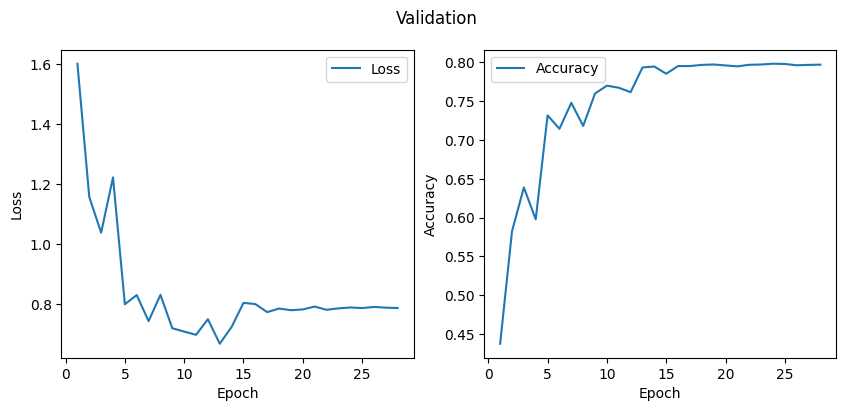

In [100]:
val_epochs = np.arange(len(val_loss_log)) + 1

fig = plt.figure(figsize=(10, 4))
fig.suptitle("Validation")

ax = fig.add_subplot(1, 2, 1)
ax.plot(val_epochs, val_loss_log, label='Loss')
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax = fig.add_subplot(1, 2, 2)
ax.plot(val_epochs, val_acc_log, label='Accuracy')
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

fig.show()

In [101]:
# test loop
model.eval()

running_loss = 0.0
running_correct = 0
running_count = 0

pbar = tqdm(dataloaders['test'])
for inputs, labels in pbar:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # get model outputs and calculate loss
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
    # compute predictions
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    
    # calculate metrics
    running_loss += loss.detach().item() * inputs.size(0)
    running_correct += correct
    running_count += inputs.size(0)
    avg_loss = running_loss / running_count
    avg_acc = running_correct / running_count
    pbar.set_description("Avg. Loss: {:.4f}, Avg. Acc: {:.4f}".format(avg_loss, avg_acc))

test_acc_final = avg_acc

  0%|          | 0/157 [00:00<?, ?it/s]

Final performance

In [102]:
train_acc_final = train_acc_log[-1]
val_acc_final = val_acc_log[-1]
print("Final Training Accuracy: {}%".format(train_acc_final * 100))
print("Final Validation Accuracy: {}%".format(val_acc_final * 100))
print("Final Testing Accuracy: {}%".format(test_acc_final * 100))

Final Training Accuracy: 99.99%
Final Validation Accuracy: 79.67%
Final Testing Accuracy: 79.66%


## Save model

In [103]:
model_fname = os.path.join("./", "Model Parameters {}".format(get_timestamp()))
torch.save(model.state_dict(), model_fname)

In [104]:
if COLAB:
    from google.colab import files
    files.download(model_fname)

## Estimate assignment grade on validation set

Run the network profiler in `network-profile.ipynb` using your model description. Then copy your result into the cell below. Please check the unit conversion, and round the value to four decimal places.

In [107]:
network_complexity = get_network_complexity_info(
    activation_size=98304.0, # activation size in Byte [TODO]
    energy=0.32204000, # estimated energy in mJ [TODO]
    latency=0.04634400) # number of cycles in Million (1e6) [TODO]

In [108]:
final_score = get_lab_score(test_acc_final, network_complexity)
print("Final Score: {}".format(final_score))

Final Score: (90, 1.8494800000000002)
